# Reinforcement Q-learning simple NN as function approximation

- portfolio grid of size 10 (0 to 1)
- 1 hidden neural layers 
- Improved by Dropout 

In [1]:
# Initialization
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data_ext.csv') #Three stocks (R,X_s,X_b,s_nom,s_pe,s_spr) 

In [9]:
data = pd.read_excel('sim_data_CER.xlsx') #Three stocks (R,X_s,X_b) Without predictors

# Initialization of the Tensorflow placeholders and the network

In [11]:
num_stocks=3

def sigmoid(x):
    return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

def sigmoidprime(x):
    return tf.multiply(sigma(x),tf.substract(tf.constant(1.0), sigma(x)))

#Initialize Neural Network and set-up the placeholders
tf.reset_default_graph()
NN_input = tf.placeholder(shape=[1,num_stocks],dtype=tf.float32)
NN_weights = tf.Variable(tf.random_uniform([num_stocks,10],0,1))
NN_dropout = tf.nn.dropout(NN_weights,0.2)
b = tf.Variable(np.zeros((1,10)), dtype=tf.float32)
# Q_FA = tf.tanh(tf.matmul(NN_input,NN_weights) + b)  
# Q_FA = tf.nn.relu(tf.matmul(NN_input,NN_dropout) + b)
Q_FA = tf.nn.relu(tf.matmul(NN_input,NN_weights) + b)
# Q_FA = tf.tanh(tf.matmul(NN_input,NN_dropout) + b)
# Q_FA = tf.matmul(NN_input,NN_weights) + b
# Q_dropout = tf.nn.dropout(Q_FA,0.2)
# A_Max = tf.argmax(Q_dropout,1)
A_Max = tf.argmax(Q_FA,1)

z = tf.add(tf.matmul(NN_input,NN_weights),b)
a = sigmoid(z)

# Calculate loss for the NN from the Q values
Q_Next = tf.placeholder(shape=[1,10],dtype=tf.float32)
# loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
# loss = tf.losses.softmax_cross_entropy(onehot_labels=Q_Next,logits=Q_dropout)
# # loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
##trainer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
# updateModel = trainer.minimize(loss)
##updateModel = trainer.minimize(tf.square(Q_Next -Q_FA))
# loss = tf.reduce_sum(tf.nn.l2_loss(Q_Next-Q_FA))
loss = tf.reduce_sum(tf.nn.l2_loss(Q_Next-z))
optmzr = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)
#Define Action Matrix (Now discrete case) 
A = np.linspace(0,1,10) # portfolio weights of stocks (1-weight) is the weight in the bonds

# Training of the NN function approximation

240


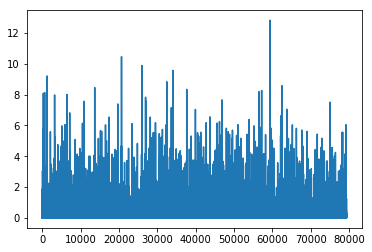

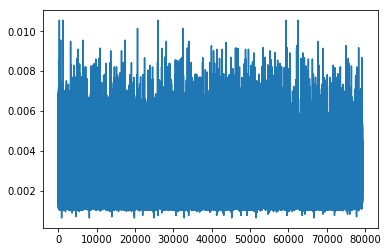

[ 0.44444444  0.33333333  0.33333333  0.44444444  0.44444444  0.33333333
  0.33333333  0.44444444  0.44444444  0.33333333  0.44444444  0.44444444
  0.33333333  0.44444444  0.44444444  0.33333333  0.33333333  0.33333333
  0.44444444  0.33333333  0.33333333  0.44444444  0.33333333  0.44444444
  0.44444444  0.44444444  0.44444444  0.44444444  0.44444444  0.33333333
  0.44444444  0.44444444  0.44444444  0.44444444  0.44444444  0.55555556
  0.44444444  0.44444444  0.55555556  0.33333333  0.44444444  0.44444444
  0.44444444  0.33333333  0.33333333  0.44444444  0.33333333  0.44444444
  0.33333333  0.44444444  0.44444444  0.44444444  0.44444444  0.55555556
  0.44444444  0.44444444  0.44444444  0.55555556  0.44444444]
1.20920311671
Writing away results
241


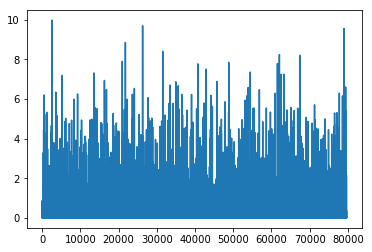

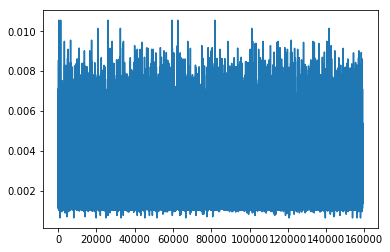

[ 0.44444444  0.44444444  0.44444444  0.44444444  0.44444444  0.55555556
  0.33333333  0.44444444  0.44444444  0.55555556  0.44444444  0.44444444
  0.55555556  0.44444444  0.44444444  0.77777778  0.44444444  0.44444444
  0.33333333  0.33333333  0.44444444  0.44444444  0.44444444  0.44444444
  0.44444444  0.33333333  0.44444444  0.44444444  0.44444444  0.44444444
  0.44444444  0.55555556  0.33333333  0.44444444  0.44444444  0.44444444
  0.33333333  0.44444444  0.33333333  0.44444444  0.55555556  0.44444444
  0.33333333  0.44444444  0.44444444  0.44444444  0.44444444  0.44444444
  0.44444444  0.44444444  0.33333333  0.44444444  0.44444444  0.44444444
  0.33333333  0.44444444  0.44444444  0.44444444  0.55555556]
1.21686637976
Writing away results
242


In [ ]:
# initialize
init = tf.global_variables_initializer()
gamma = 0.98
epsilon = 0.1
TWlist = []
Index = []
MWeights = []
Turnover = []
chooserlist = []
RU = []
learningrateQ = 1
n = 707
startE = 1
endE = 0.01
periods = 60
epochs = 5     # preferred to have a low amount of epochs because otherwise the the same data is used multiple times (usually not the case in stock returns)

# data parsing
dates = data['Date']
# mdata = data[['r','xs','xb','snom','spe','sspr']]
mdata = data[['r','xs','xb']]
mdata.index = pd.DatetimeIndex(dates)

with tf.Session() as sess:
    for i in range(240,int(n-periods-1)):
        lostlist = []
        OptimalWeights = np.zeros(periods-1)
        currentK = 0
        
        
        print(i)
        rlist = []
        NN_data = mdata[0:i+currentK]
        
        
        # Scaling of the returns (otherwise Q values will grow indefinitely)
        for x in range(0,len(NN_data)):
            for y in range(0,10):
                rlist.append(A[y]*NN_data.iloc[x,:][1]+(1-A[y])*NN_data.iloc[x,:][2])

#         epsilon = 1
#         learningrateQ = 1
#         gamma = 0.5
#         gamma_dec = (1 - 0.5)/(epochs*(int(len(NN_data)+periods)))
#         lrq_dec = (1-0.01)/(epochs*(int(len(NN_data)+periods)))
#         epsilon_dec = (startE-endE)/(epochs*(int(len(NN_data)+periods)))
            
        while currentK < periods - 1:
            sess.run(init) # initialize the Neural Network again
#             if(currentK == 0):
#                 NN_data = mdata[0:i+currentK]
#             else:
#                 NN_data = mdata[i+currentK-100:i+currentK]
            NN_data = mdata[0:i+currentK]
#             NN_data = mdata[0:i+currentK]  # Expanding window
            currentEpoch = 0
            for y in range(0,10):
                rlist.append(A[y]*NN_data.iloc[-1,:][1]+(1-A[y])*NN_data.iloc[-1,:][2])
           
                    
            indexes = np.asarray(range(len(NN_data)))
            np.random.shuffle(indexes)
            
            while currentEpoch < epochs:
#                 epsilon -= epsilon_dec
#                 gamma += gamma_dec
#                 learningrateQ -= lrq_dec
                #Training of the Q-Network for the data available (with Neural Nets) 
                for j in indexes:
                    s = NN_data.iloc[j,:].values.reshape(1,num_stocks)
                    #Choose an action by greedily (with e chance of random action) from the Q-network
                    a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
                    a = A[a_int-1]  # -1 because the output neurons are labeled 1 till 101 and it will be an index
#                     print(A[a_int-1])
                    if np.random.rand(1) < epsilon:
                        a = random.choice(A)

                    #Get new state and reward from environment
#                     print(s)
                    
                    s1 = mdata.iloc[j+1,:].values.reshape(1,num_stocks)
#                     print(s1)
#                     print(mdata.iloc[j,:].values)
#                     print('x')
                    r = (a*s1[0][1] + (1-a)*s1[0][2]) #reward: this is now the wealth gained from this step, but could be other rewards like utility
                    Q = sess.run(Q_FA,feed_dict={NN_input:s1})
#                     print(Q)
                    #Obtain maxQ' and set our target value for chosen action.
#                     print(Q)
                    Q1 = np.max(Q)
                    targetQ = allQ
#                     print(targetQ)
#                     print((r-rmean)/rstd)
                    rmean = np.mean(rlist)
                    rstd = np.std(rlist)
#                     print((r-rmean)/rstd)
#                     print(r)
#                     targetQ[0,int(a*9)] = (r-rmean)/rstd + gamma*Q1
                    targetQ[0,int(a*9)] = targetQ[0,int(a*9)] + learningrateQ*((r-rmean)/rstd + gamma*Q1 - targetQ[0,int(a*9)]) 
                    chooserlist.append(r)
#                     print(targetQ)
                    #Train the neural network using target and predicted Q values
                    _,W1,loss_ = sess.run([optmzr,NN_weights,loss],feed_dict={NN_input:s,Q_Next:targetQ})
#                     print(W1)
                    s =  mdata.iloc[j+1,:].values.reshape(1,num_stocks)
                    lostlist.append(loss_)
                currentEpoch += 1
            

            # After training now calculate the optimal weights for the K=60 periods to come
            s = mdata.iloc[i+periods,:].values.reshape(1,num_stocks)
            a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
#             print(allQ)
#             print(a_int)
            aOpt = A[a_int-1]
            OptimalWeights[currentK] = aOpt
            currentK += 1
            
        # For insight purposes (Write away)
        plt.ion()
        plt.plot(lostlist)
        plt.show()
        plt.plot(chooserlist)
        plt.show()
        
        firstdiff = OptimalWeights[1:] - OptimalWeights[:-1]
        MWeights.append(np.mean(OptimalWeights))
        TerminalWealth = np.exp(sum(OptimalWeights*mdata[i+1:i+currentK+1]['xs'] + (1-OptimalWeights)*mdata[i+1:i+currentK+1]['xb']))
        TWlist.append(TerminalWealth)
        Index.append(i)
        Turnover.append(sum(abs(firstdiff*np.exp(mdata[i+1:i+currentK]['xs'])) + abs((1-firstdiff)*np.exp(mdata[i+1:i+currentK]['xb']))))
        RU.append((1/(1-5))*pow(TerminalWealth,(1-5)))
        print(OptimalWeights)
        print(TerminalWealth)
        
        print('Writing away results')
        df = pd.DataFrame({'index date':Index,'TW':TWlist, 'Mean Weights Xs':MWeights,'Turnover':Turnover, 'Realized Utility':RU})
        df.to_excel('NN_test_CER_2.xlsx', sheet_name='sheet1', index=False)
print('Done!')
        